In [2]:
import os
import pyramses
import glob
import numpy
import cmath
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image


# Upload all the load flow files solved through Artere

In [11]:
list_of_files = []
for j in range(1,5):
    list_files = ('If_A'+r"%s"% j+'.DAT')
    list_of_files.append(list_files)

In [12]:
list_of_files

['If_A1.DAT', 'If_A2.DAT', 'If_A3.DAT', 'If_A4.DAT']

Set up the scenario
================

In [13]:
def data(x):

    case = pyramses.cfg() # Create a new scenario
    case.addData('dyn_A.dat') # Dynamic data file
    case.addData(x) # Power-flow (static) data
    case.addData('settings1.dat') # Solver settings
    case.addObs("obs.dat") # File with the variables to be saved for offline analysis
    case.addTrj("out.trj") # File for saving the variables for offline analysis
    case.addDst('trip_branch.dst') # Description of disturbance
#     case.addDst('trip_branch.dst') # Description of disturbance
#     case.addDst('trip_branch.dst') # Description of disturbance
#     case.addDst('short_trip_branch_2.dst') # Description of disturbance
    

    # Define the boundary buses to monitor
    # An important part of the monitoring method is to define the buses and lines to be
    # monitored by the PMUs.These are selected to be the same as in [1]

    branchName = ['4031-4041','4031-4041-2','4021-4042','4032-4042','4041-4044','4032-4044','4042-4044'] # Lines to be monitored
    busName = ['4041','4042','4044'] # Buses to be monitored

    # Define empty lists to save running values

    lP4041 = [] ; lP4042 = [] ; lP4044 = [] ; lG4041 = [] ; lG4042 = [] ;lG4044 = []
    lDeltaG4041 = [] ; lDeltaG4042 = [] ;lDeltaG4044 = [] ;lDeltaP4041 = [] ; lDeltaP4042 = [];lDeltaP4044 = []
    NLI4041 = [] ; NLI4042 = []; NLI4044= []
    avNLI4041 = [] ; avNLI4042 = [] ; avNLI4044 = []
    time4041 = [] ; time4042 = [] ; time4044 = [] ; rawtime = []


    # Define monitoring parameters

    epsilon = 0.001
    N = 10  # samples
    thorizon = 251.0 # seconds
    Tsample = 0.5 # seconds

    # where 𝜖 is the threshold used to filter out measurements as discussed in Eq. 15 of [1], 
    # 𝑁 defines the number of samples averaged for all averaging functions, 𝑇 𝑠𝑎𝑚𝑝𝑙𝑒 is the sampling
    # time for getting the measurements, and 𝑡ℎ𝑜𝑟𝑖𝑧𝑜𝑛 is the simulation time if a fault is not found first.

    # Define support functions

    # There are two support functions implemented here to get the measurements and compute 
    # the NLI indices.If you are not familiar with the methodology, you can skip reading them. 
    # The function get_measurements gets a measurements of the active powers and currents on
    # the boundary buses. Unlike the paper, we do not add any measurement noise


    def get_measurements(ram, busName, branchName):

        # Returns a list where each element has the from/to active/reactive powers of a branch. All values are in per-unit.
        # Powers list contains the following:
        # [[4031-4041-Porig, 4031-4041-Qorig, 4031-4041-Pextr, 4031-4041-Pextr]
        #  [4031-4041-2-Porig, 4031-4041-2-Qorig, 4031-4041-2-Pextr, 4031-4041-2-Pextr]
        #  [4021-4042-Porig, 4021-4042-Qorig, 4021-4042-Pextr, 4021-4042-Pextr]
        #  [4032-4042-Porig, 4032-4042-Qorig, 4032-4042-Pextr, 4032-4042-Pextr]]
        # All the powers are assumed towards the line. That is, the lines losses are Ploss = Porig+Pextr, Qloss = Qorig+Qextr
        # The minus sign below is used because we want the power going into the bus.
        powers = ram.getBranchPow(branchName) 
        P4041 = - (powers[0][2] + powers[1][2])
        P4042 = - (powers[2][2] + powers[3][2])
        P4044 = - (powers[4][2] + powers[5][2]+ powers[6][2])

        # Returns a list where each element has the from/to x/y current component of a branch. All values are in per-unit.
        # The list below has the same structure as the one above
        currents = ram.getBranchCur(branchName) 
        Ix4041 = - (currents[0][2] + currents[1][2])
        Iy4041 = - (currents[0][3] + currents[1][3])
        Ix4042 = - (currents[2][2] + currents[3][2])
        Iy4042 = - (currents[2][3] + currents[3][3])
        Ix4044 = - (currents[4][2] + currents[5][2] + currents[6][2] )
        Iy4044 = - (currents[4][3] + currents[5][3] + currents[6][3])

        I4041 = complex(Ix4041, Iy4041)
        I4042 = complex(Ix4042, Iy4042)
        I4044 = complex(Ix4044, Iy4044)

        # Return the bus voltage magnitude and phase
        voltageMag = ram.getBusVolt(busName)
        voltagePha = ram.getBusPha(busName)

        # Formulate complex voltages of the boundary bases
        voltage4041 = cmath.rect(voltageMag[0], voltagePha[0])
        voltage4042 = cmath.rect(voltageMag[1], voltagePha[1])
        voltage4044 = cmath.rect(voltageMag[2], voltagePha[2])

        #Compute the conductance
        G4041 = (I4041 / voltage4041).real
        G4042 = (I4042 / voltage4042).real
        G4044 = (I4044 / voltage4044).real

        return P4041, P4042,P4044, G4041, G4042,G4044

    # The function update_NLI updates the NLI index at time t for each of the boundary buses:

    def update_NLI(t, lP, lG, N, epsilon, lDeltaG, lDeltaP, NLI, avNLI, time):
        if len(lP) > 2:
            # Compute eqs. 13-14 in [1]
            if len(lG) > N+1 :
                DeltaG = np.mean(lG[-N:-1]) - np.mean(lG[-N-1:-2])
                DeltaP = np.mean(lP[-N:-1]) - np.mean(lP[-N-1:-2])
            else:
                DeltaG = np.mean(lG[:-1]) - np.mean(lG[:-2])
                DeltaP = np.mean(lP[:-1]) - np.mean(lP[:-2])

            # Check eq 15 in [1] if the measurement is acceptable
            if (DeltaG / lG[-1]) > epsilon: 
                lDeltaG.append(DeltaG)
                lDeltaP.append(DeltaP)
                if len(lDeltaP) > N:
                    # Compute eq. 17 in [1]
                    NLIk = np.mean(lDeltaP[-N:-1]) / np.mean(lDeltaG[-N:-1])
                    NLI.append(NLIk)
                    if len(NLI) > N:
                        # Compute moving average of eq. 17 in [1]
                        avNLI.append(np.mean(NLI[-N:-1]))  
                        time.append(t)

    ram = pyramses.sim() # Create a new simulator instance
    ret = ram.execSim(case, 0) # Start the simulation of the scenarion paused at t=0 seconds

    for t in np.arange(0.0,thorizon,Tsample):

        # Simulates until the next sampling point. If there is an error, then exit the loop printing the error.
        try:
            ram.contSim(t)
        except:
            print(ram.getLastErr())
            break

        # Get the recent measurements of Power (P) and Conductance (G)
        P4041, P4042,P4044, G4041, G4042,G4044 = get_measurements(ram, busName, branchName)

        # Update the values of NLI
        update_NLI(t, lP4041, lG4041, N, epsilon, lDeltaG4041, lDeltaP4041, NLI4041, avNLI4041, time4041)
        update_NLI(t, lP4042, lG4042, N, epsilon, lDeltaG4042, lDeltaP4042, NLI4042, avNLI4042, time4042)
        update_NLI(t, lP4044, lG4044, N, epsilon, lDeltaG4044, lDeltaP4044, NLI4044, avNLI4044, time4044)
       
        # Update the list of measurements
        lP4041.append(P4041)
        lP4042.append(P4042)
        lP4044.append(P4044)
        lG4041.append(G4041)
        lG4042.append(G4042)
        lG4044.append(G4044)
        rawtime.append(t)


    ext = pyramses.extractor(case.getTrj())
#     v4041 = ext.getBus('4041').mag
#     v4042 = ext.getBus('4042').mag
#     v4044 = ext.getBus('4044').mag
#     fig=plt.figure(figsize=(20,10), facecolor='w', edgecolor='k')
#     plt.plot(v4041.time, v4041.value, 'b', label=v4041.msg)
#     plt.plot(v4042.time, v4042.value, 'r', label=v4042.msg)
#     plt.plot(v4044.time, v4044.value, 'k', label=v4044.msg)
#     plt.ylabel('V (pu)')
#     plt.xlabel('time(s)')
#     plt.legend(loc='upper right')
#     plt.xticks(np.arange(0, 160, 15))
#     plt.yticks(np.arange(0.85, 1.05, 0.05))
#     plt.ylim(0.83, 1.07)
#     plt.grid(b=True, which='major', color='#666666', linestyle='-')
#     plt.title('Fig 9 of [1]')
#     plt.show()


    a = len(avNLI4041)
    b = len(avNLI4042)
    c = len(avNLI4044)
    d = [a,b,c]
    e = np.min(d)



    nli = pd.DataFrame()
    nli['avNLI4042'] = avNLI4042[0:e]
    nli['avNLI4041'] = avNLI4041[0:e]
    nli['avNLI4044'] = avNLI4044[0:e]
    nli['time'] = time4041[0:e]

   
    class dataframe:
        def __init__(self,bus_name):
            self.busName = bus_name


        def V_mag(self):

            for i in self.busName:
                a = ext.getBus(i).mag
                main.append((a))

            return (main)

        def vu(self):

            val = self.V_mag()

            for i in range(0,len(self.busName)):

                mag=val[i].value
                valu.append(mag)

        def make_df(self):

            y = self.vu()
            df = pd.DataFrame(valu)
            df = df.T
            df.columns = self.busName
            df['Time'] = main[0].time
            df.set_index("Time", inplace = True)
            return df

    r = dataframe(bus_name)
    vol_mag = r.make_df()
    vol_mag.head()

    
#     vol_mag = vol_mag.drop_duplicates()
#     vol_mag['nli'] = 0
#     zero_crossings = numpy.where(numpy.diff(numpy.sign(nli['avNLI4044'])))[0]
#     ftd = nli.iloc[zero_crossings]
#     ftd['time'].iloc[0]
#     gp = []
#     for i in range(0,len(ftd)):
#         skd = np.where(vol_mag.index ==round(ftd['time'].iloc[i]))
#         gp.append(skd)
#     for i in range(0,len(gp)):
#         vol_mag['nli'].iloc[gp[i]] = 2


#     vol_mag = vol_mag.drop_duplicates()
#     zero_crossings = numpy.where(numpy.diff(numpy.sign(nli['avNLI4042'])))[0]
#     ftd = nli.iloc[zero_crossings]
#     ftd['time'].iloc[0]
#     gp = []
#     for i in range(0,len(ftd)):
#         skd = np.where(vol_mag.index ==round(ftd['time'].iloc[i]))
#         gp.append(skd)
#     for i in range(0,len(gp)):
#         vol_mag['nli'].iloc[gp[i]] = -1
    

#     zero_crossings = numpy.where(numpy.diff(numpy.sign(nli['avNLI4041'])))[0]
#     ftd = nli.iloc[zero_crossings]
#     ftd['time'].iloc[0]
#     gp = []
#     for i in range(0,len(ftd)):
#         skd = np.where(vol_mag.index == round(ftd['time'].iloc[i]))
#         gp.append(skd)
#     for i in range(0,len(gp)):
#         vol_mag['nli'].iloc[gp[i]] = 1

        
    

    
    return(vol_mag)

In [1]:
for i in range (1,3):
    vol_mag = data(list_of_files[i])
#   vol_mag.to_csv('D:/all_generated_data/load_140_percent_tb/vol_mag'+r"%s"% i +'.csv')

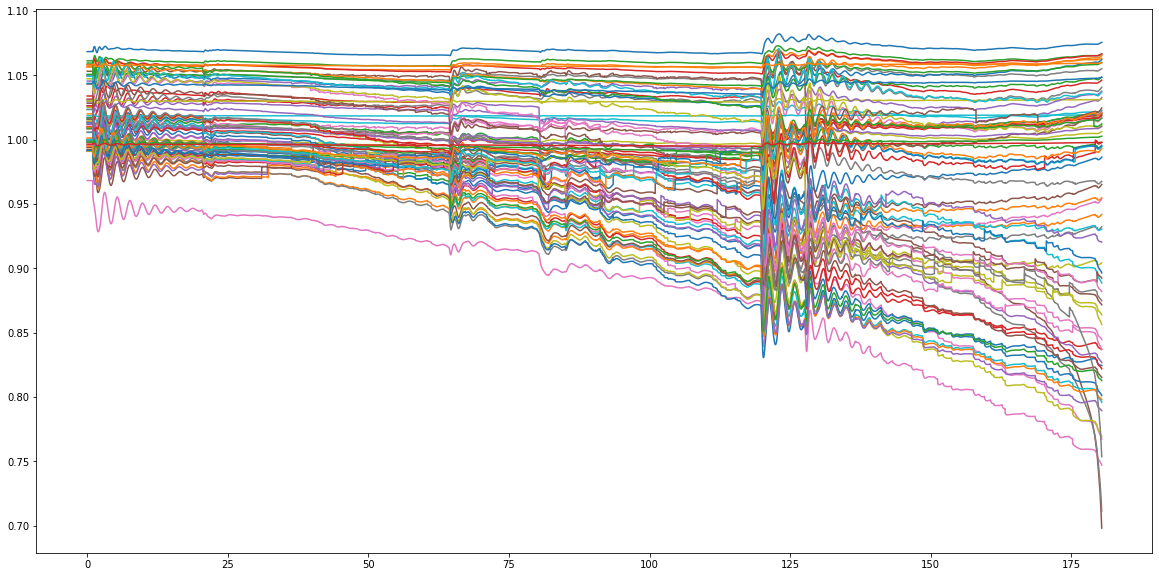

In [18]:
fig=plt.figure(figsize=(20,10), facecolor='w', edgecolor='k')
plt.plot(vol_mag)
plt.show()